In [1]:
import sys
sys.path.append('../')
import json
from typing import List
from tqdm import tqdm
import glob
import os
import numpy as np
from collections import defaultdict
from skimage.color import rgb2gray
from skimage import io
from PIL import Image, ImageOps
from extract_entity import classify_all_entity, bfs, extract_bbox

/home/khangln/miniconda3/envs/trans2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Icon classifier components
loading pretrained models on icon data:  /home/khangln/JAIST_DRIVE/WORK/IconQA/saved_models/icon_classification_ckpt/icon_resnet101_LDAM_DRW_lr0.01_0/ckpt.epoch66_best.pth.tar


/home/khangln/miniconda3/envs/trans2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/khangln/miniconda3/envs/trans2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Finish loading Icon classifier components


In [21]:
def classify_all_entity(img_path, min_pixels=100):
    ret = []
    img = io.imread(img_path)
    img = img[3:-3, 3:-3]
    img[np.logical_and(img[:, :, 0] == 178, img[:, :, 1] ==
                       235, img[:, :, 2] == 255)] = [255, 255, 255]
    gimg = rgb2gray(img)
    # Set almost white pixel to white
    # gimg[gimg > 0.85] = 1.0

    bboxs = extract_bbox(gimg)
    bboxs = [b for b in bboxs if abs(b[2]-b[0]+1)*abs(b[3]-b[1]) >= min_pixels]
    pis = []
    for b in bboxs:
        top, left, bottom, right = b
        pi = Image.fromarray(img[top:bottom+1, left:right+1])
        # entity_class = classify_img(pi)
        # ret.append(entity_class)
        pis.append(pi)
    return  pis, gimg

In [22]:
pis, im = classify_all_entity('/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa/test/choose_img/4/image.png')

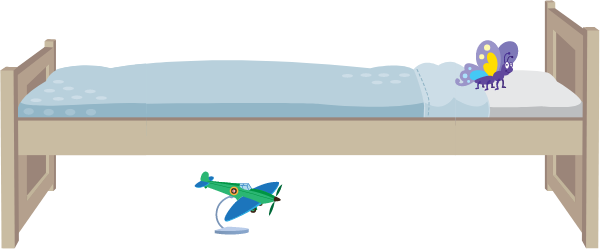

In [23]:
pis[1]

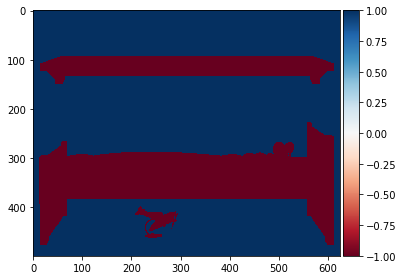

In [24]:
io.imshow(im)

In [18]:
new_im = [x for x in im]

In [32]:
new_im = np.array([[[255,0,0] if c == -1 else [255,255,255] for c in r]  for r in im])

In [39]:
new_im.astype(np.uint8)

array([[[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]],

       [[255,   0,   0],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255,   0,   0],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255,   0,   0],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255,   0,   0],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255,   0,   0],
        [255,   0,   0],
        [255,   0,   0],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]

/home/khangln/miniconda3/envs/trans/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


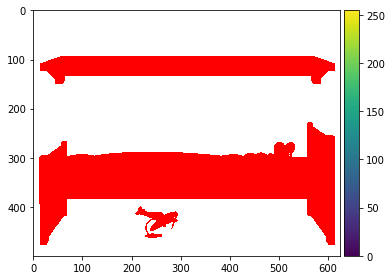

In [34]:
io.imshow(new_im)

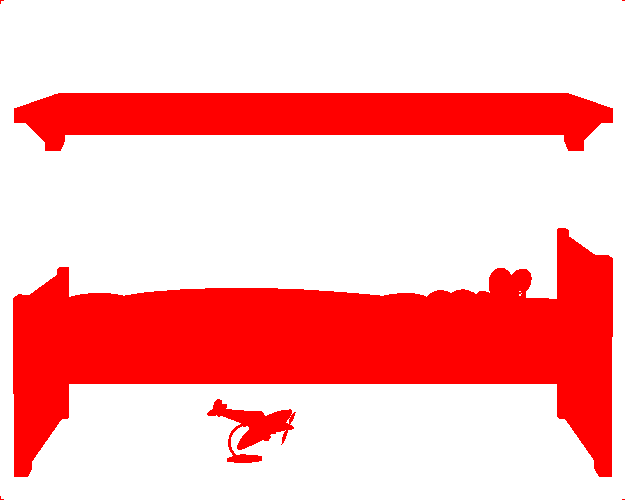

In [40]:
Image.fromarray(new_im.astype(np.uint8))

In [1]:
# Load model and retrieve attention weights

from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel, RobertaForMultipleChoice, RobertaTokenizer, BertForQuestionAnswering
import torch

model_version = '/home/khangln/H_JAIST_DRIVE/WORK/iconqa_project/entity-detect-for-iconqa/models/bert-base-cased-train-both-img-txt'
model = BertForQuestionAnswering.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "Which group has more?"
sentence_b = "3 sign, 5 lemon"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

/home/khangln/miniconda3/envs/trans2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /home/khangln/H_JAIST_DRIVE/WORK/iconqa_project/entity-detect-for-iconqa/models/bert-base-cased-train-both-img-txt were not used when initializing BertForQuestionAnswering: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification m

In [2]:
def visualize_info(sent1,sent2):
    inputs = tokenizer.encode_plus(sent1, sent2, return_tensors='pt')
    input_ids = inputs['input_ids']
    token_type_ids = inputs['token_type_ids']
    attention = model(input_ids, token_type_ids=token_type_ids)[-1]
    sentence_b_start = token_type_ids[0].tolist().index(1)
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list) 
    att_shape = attention[0].shape
    my_att = [torch.broadcast_to(torch.sum(att, dim=1, keepdim=True), (1,12, att_shape[2], att_shape[3])) for att in attention]
    return my_att, tokens, sentence_b_start

head_view(*visualize_info("Which group has more?", "3 sign, 5 lemon"))

<IPython.core.display.Javascript object>

In [11]:
prompt = "Which group has fewer? 5 bug, 4 leaf"
candidates = ['5 bug',  '10 leaf', '2 bug','4 leaf']

In [12]:
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice

tokenizer = AutoTokenizer.from_pretrained("/home/khangln/H_JAIST_DRIVE/WORK/iconqa_project/entity-detect-for-iconqa/models/bert-base-cased-train-both-img-txt")
model = AutoModelForMultipleChoice.from_pretrained("/home/khangln/H_JAIST_DRIVE/WORK/iconqa_project/entity-detect-for-iconqa/models/bert-base-cased-train-both-img-txt")
model.to('cuda')
inputs = tokenizer([[prompt, x] for x in candidates], return_tensors="pt", padding=True).to('cuda')
with torch.no_grad():
    outputs = model(**{k: v.unsqueeze(0) for k, v in inputs.items()})
    logits = outputs.logits
    predicted_class = logits.argmax().item()
    

In [13]:
predicted_class

3

In [14]:
type(tokenizer)

transformers.models.bert.tokenization_bert_fast.BertTokenizerFast

In [15]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [5]:
def get_question_dict():
    q_dict = {}
    with open('problems_dict.json') as f:
        problem_dict = json.load(f)
    for problem in problem_dict.values():
        if problem['split'] not in q_dict:
            q_dict[problem['split']] = {}
        split_dict = q_dict[problem['split']]
        if problem['ques_type'] not in split_dict:
            split_dict[problem['ques_type']] = [problem]
        else:
            split_dict[problem['ques_type']].append(problem)
    return q_dict

In [7]:
a = get_question_dict()

In [11]:
a['test']['choose_img']

[{'question': 'Which object is below the bed?',
  'choices': ['choice_0.png', 'choice_1.png'],
  'answer': 0,
  'ques_type': 'choose_img',
  'grade': 'prek',
  'label': 'F6',
  'split': 'test'},
 {'question': 'Which shape has a curved part?',
  'choices': ['choice_0.png', 'choice_1.png'],
  'answer': 1,
  'ques_type': 'choose_img',
  'grade': 'kindergarten',
  'label': 'V8',
  'split': 'test'},
 {'question': 'Which shape has more sides?',
  'choices': ['choice_0.png', 'choice_1.png'],
  'answer': 0,
  'ques_type': 'choose_img',
  'grade': 'grade1',
  'label': 'V5',
  'split': 'test'},
 {'question': 'Which figure shows fourths?',
  'choices': ['choice_0.png', 'choice_1.png'],
  'answer': 0,
  'ques_type': 'choose_img',
  'grade': 'grade1',
  'label': 'X5',
  'split': 'test'},
 {'question': 'Which group has 7 squares?',
  'choices': ['choice_0.png', 'choice_1.png'],
  'answer': 0,
  'ques_type': 'choose_img',
  'grade': 'prek',
  'label': 'C13',
  'split': 'test'},
 {'question': 'Which t

In [13]:
ICON_QA_DATA_DIR = '/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa'
example_paths = glob.glob(os.path.join(ICON_QA_DATA_DIR, '*/*/*'))

In [14]:
example_paths

['/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa/test/choose_img/64839',
 '/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa/test/choose_img/76365',
 '/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa/test/choose_img/45255',
 '/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa/test/choose_img/79941',
 '/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa/test/choose_img/3298',
 '/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa/test/choose_img/45510',
 '/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa/test/choose_img/88441',
 '/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa/test/choose_img/30361',
 '/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa/test/choose_img/103139',
 '/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa/test/choose_img/101194',
 '/home/khangln/JAIST_DRIVE/WORK/IconQA/data/iconqa_data/iconqa/test/choose_img/12479',
 '/home/khangln/JAIST_DRIVE/WOR